# Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, make_scorer, balanced_accuracy_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import EditedNearestNeighbours
import pickle


#importing the training dataset
url = 'https://raw.githubusercontent.com/ArvinCorotana/ML/main/TrainDataset2023.xls'
dataset = pd.read_excel(url, sheet_name='Sheet1')
dataset.replace(999, np.nan, inplace=True)
dataset = dataset.dropna(subset=['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], how='any')




#splitting the data and dropping targets which has nan values
def data_split(dataset):
    dataset.drop('ID',axis=1,inplace=True)
    X = dataset.iloc[:, 2:]
    y = dataset.iloc[:, :2]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    data = pd.concat((y_test,X_test),axis=1)
    data = data.dropna(how='any')
    X_test = data.iloc[:, 2:]
    y_test = data.iloc[:,:2]
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    return X_train, X_test, y_train, y_test

#imputing the missing values with their corresponding mode
def imputation(X_train):
    imputer = SimpleImputer(strategy='most_frequent')
    imputer.fit(X_train)
    X_train_imputed = imputer.transform(X_train)
    X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)
    with open('imputer.pkl', 'wb') as file:
        pickle.dump(imputer, file)
    return X_train_imputed

#Detecting outlier and modifying with max and min quantile values
def outlier(mri_features):

    mri_features_copy = mri_features.copy()
    Q1 = mri_features_copy.quantile(0.25)
    Q3 = mri_features_copy.quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - (1.5 * IQR)
    upper_lim = Q3 + (1.5 * IQR)


    for column in mri_features_copy:
        outliers = ((mri_features_copy[column] < lower_lim[column]) |
                    (mri_features_copy[column] > upper_lim[column]))


        mri_features_copy.loc[outliers, column] = mri_features_copy.loc[outliers, column].apply(lambda x: lower_lim[column] if x < lower_lim[column] else upper_lim[column])

    return mri_features_copy

#dropping RFS and squeezing the target varaibles
def target(y_train,y_test):
    y_train = y_train.drop('RelapseFreeSurvival (outcome)', axis=1)
    y_train = y_train.squeeze()
    y_test = y_test.drop('RelapseFreeSurvival (outcome)', axis=1)
    y_test = y_test.squeeze()
    return y_train,y_test

#oversampling to address the data imbalance
def oversampling(X_train,y_train):
    sm = SMOTE(sampling_strategy='minority', k_neighbors=5, random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    return X_train,y_train

#scaling the data using minmax scaler
def normalization(X_train,X_test_imputed):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = scaler.transform(X_test_imputed)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)
    with open('minmax.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    return X_train,X_test_imputed

#removing the features which are highly correlated among each other
def feature_selection(X_train_new,X_test_new):
    correlation_matrix = X_train_new.corr()
    correlation_matrix = abs(correlation_matrix)
    mask = np.triu(np.ones(correlation_matrix.shape), k=1)
    correlation_features = correlation_matrix[correlation_matrix > 0.85]
    columns_to_drop = [column for column in correlation_features.columns if (correlation_features[column] > 0).sum() > 3]
    X_train_new = X_train_new.drop(columns=columns_to_drop)
    X_test_new = X_test_new.drop(columns=columns_to_drop)
    columns = X_train.columns.tolist()
    with open('features.pkl', 'wb') as file:
        pickle.dump(columns, file)
    return X_train_new,X_test_new

#wrapping all the data-preprocessing functions
def data_processing(dataset):
    X_train, X_test, y_train, y_test = data_split(dataset)
    X_train = imputation(X_train)
    y_train,y_test = target(y_train,y_test)
    X_train,y_train = oversampling(X_train,y_train)
    X_train_clinical = X_train.iloc[:,:10]
    X_test_clinical = X_test.iloc[:,:10]
    X_train_mri = X_train.iloc[:,10:]
    X_test_mri = X_test.iloc[:,10:]
    X_train_mri = outlier(X_train_mri)
    X_train_mri,X_test_mri = normalization(X_train_mri,X_test_mri)
    X_train_mri,X_test_mri = feature_selection(X_train_mri,X_test_mri)
    X_train = pd.concat([X_train_clinical, X_train_mri], axis=1)
    X_test= pd.concat([X_test_clinical, X_test_mri], axis=1)

    return X_train, X_test, y_train, y_test


#definiting an MLP model
def MLP(X_train, X_test, y_train, y_test):
    print('mlp')
    mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'invscaling', 'adaptive']
    }
    grid_search = GridSearchCV(mlp, param_grid, scoring='balanced_accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_mlp = grid_search.best_estimator_
    with open('best_mlp_model.pkl', 'wb') as file:
        pickle.dump(grid_search, file)    
    print("Best parameters found during GridSearchCV:", grid_search.best_params_)
    y_pred = best_mlp.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy on test set: {balanced_accuracy:.4f}')
    cv_scores = cross_val_score(best_mlp, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='balanced_accuracy')
    print("Cross-Validation Accuracy Score for each fold:", cv_scores)
    print(f"Mean CV Accuracy for the best MLP model: {cv_scores.mean():.2%}")



#svc 
def svc(X_train, X_test, y_train, y_test):
    print('SVC')
    svm = SVC()
    svm.fit(X_train, y_train)
    print("Default SVM Accuracy:", svm.score(X_test, y_test))
    param_grid = {'C': [0.01, 1, 10],
                  'gamma': [0.01, 1, 'scale'],
                  'kernel': ['linear', 'rbf']}
    grid_search = GridSearchCV(svm, param_grid, cv=StratifiedKFold(n_splits=5), scoring='balanced_accuracy')
    grid_search.fit(X_train, y_train)
    final_svm = grid_search.best_estimator_
    with open('best_svm_model.pkl', 'wb') as file:
        pickle.dump(final_svm, file)
    accuracy = final_svm.score(X_test, y_test)
    print(f"Model Accuracy on test set: {accuracy: .2%}")
    y_pred = final_svm.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f"Balanced Accuracy for the best SVM model: {balanced_accuracy:.2%}")
    cv_scores = cross_val_score(final_svm, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='balanced_accuracy')
    print("Cross-Validation Accuracy Score for each fold:", cv_scores)
    print(f"Mean CV Accuracy for the best SVM model: {cv_scores.mean():.2%}")



#logistic regression
def logistic_regression(X_train, X_test, y_train, y_test):
    print('lr')
    logreg = LogisticRegression(random_state=42)

    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga']
    }

    grid_searchlr = GridSearchCV(logreg, param_grid, scoring='balanced_accuracy', cv=5)
    grid_searchlr.fit(X_train, y_train)

    best_logreg = grid_searchlr.best_estimator_

    print("Best parameters found during GridSearchCV:", grid_searchlr.best_params_)
    with open('best_lr_model.pkl', 'wb') as file:
        pickle.dump(grid_searchlr, file)

    cv_scores = cross_val_score(best_logreg, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='balanced_accuracy')
    print("Cross-Validation Accuracy Score for each fold:", cv_scores)
    print(f"Mean CV Accuracy for the best SVM model: {cv_scores.mean():.2%}")
    y_pred = best_logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy on test set: {accuracy:.4f}')
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy on test set: {balanced_accuracy:.4f}')

def decision_Tree(X_train, X_test, y_train, y_test):
    print('DT')
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)

    accuracy = dt.score(X_test, y_test)
    print(f"Default Model Accuracy on test set: {accuracy: .2%}")

    param_grid = {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 5, 10, 15, 20, 25, 30],
        'min_samples_split': [2, 5, 10, 15, 20],
        'min_samples_leaf': [1, 2, 4, 8, 12],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced']
    }
    cv = StratifiedKFold(n_splits=3)

    grid_search_decision = GridSearchCV(dt, param_grid, scoring='balanced_accuracy', cv=cv)
    grid_search_decision.fit(X_train, y_train)

    best_decision = grid_search_decision.best_estimator_
    accuracy = best_decision.score(X_test, y_test)
    print(f"Model Accuracy on test set: {accuracy: .2%}")

    with open('best_dt_model.pkl', 'wb') as file:
        pickle.dump(grid_search_decision, file)

    y_pred = best_decision.predict(X_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')

#random forest
def RandomForest(X_train, X_test, y_train, y_test):
    print('Random Forest')
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    print(f'Model Accuracy = {rf.score(X_test, y_test): .2%}')
    param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None],
              'bootstrap': [True, False],
              'criterion': ['gini', 'entropy']}

    grid_search_random_forest = GridSearchCV(rf, param_grid, cv=5, scoring='balanced_accuracy')
    grid_search_random_forest.fit(X_train, y_train) #GirdCV taking a long time
    grid_search_random_forest.score(X_test, y_test)
    best_random = grid_search_random_forest.best_estimator_
    accuracy = best_random.score(X_test, y_test)
    print(f"Model Accuracy on test set ={accuracy: .2%}")
    y_pred = best_random.predict(X_test)

    with open('best_rf_model.pkl', 'wb') as file:
        pickle.dump(grid_search_random_forest, file)

    balance = balanced_accuracy_score(y_test,y_pred)
    print("Balanced:", balance)
    print(confusion_matrix(y_test, y_pred))

X_train, X_test, y_train, y_test = data_processing(dataset)





In [ ]:
#calling the models for training
MLP(X_train, X_test, y_train, y_test)
logistic_regression(X_train, X_test, y_train, y_test)
RandomForest(X_train, X_test, y_train, y_test)
decision_Tree(X_train, X_test, y_train, y_test)
svc(X_train, X_test, y_train, y_test)


# Regression

In [23]:
# @title libraries
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
import matplotlib.pyplot as plt
#from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import plotly.express as px
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression, RFE
import pickle
from sklearn.metrics import make_scorer


from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso#
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

In [24]:
# @title Some Utility Functions
def reg_metrics(true, pred):
  mse = mean_squared_error(true, pred)
  mae = mean_absolute_error(true, pred)
  r2 = r2_score(true, pred)
  return mse, mae, r2

def plot_output(y_test, y_pred):
  y_test, y_pred = np.array(y_test), np.array(y_pred)
  plt.figure(figsize=(10, 6))
  plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted', alpha=0.7)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
  plt.title('Actual vs. Predicted Values')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.legend()
  plt.show()

def pca(data, var=0.95, return_df=True):
  pca = PCA(n_components=var)
  data = pca.fit_transform(data)
  if return_df:
    data = pd.DataFrame(data)
  return data

## Data-Preprocessing

In [26]:
class Preprocess:
  def __init__(self, data, label):
    self.data = data
    self.label = label
    self.categorical_features = None
    self.numerical_features = None

  def preprocess_data(self):
    dataset = self.data
    self.categorical_features = dataset.columns[1:10]
    self.numerical_features = [i for i in list(dataset.columns) if not i in self.categorical_features]


    # Handle missing values
    dataset.replace(999, np.nan, inplace=True)
    dataset = self.imputation(dataset)

    # Handle outliers
    dataset = self.handle_outliers(dataset)

    # Feature Selection
    # dataset = self.feature_selection(dataset, self.label, num_features_to_select=30)
    dataset = self.feature_selection(dataset)

    # Correct skewness
    # dataset = self.correct_skewness(dataset)

    # Normalisation
    dataset, self.label = self.normalize(dataset, self.label)

    # Split Train-Test data
    print(dataset.shape, self.label.shape)
    X_train, X_test, y_train, y_test = self.split_train_test(dataset, self.label)


    return X_train, X_test, y_train, y_test

  def imputation(self, dataset):
    columns=dataset.columns
    index=dataset.index
    imputer = SimpleImputer(strategy='most_frequent')
    dataset = imputer.fit_transform(dataset)
    dataset = pd.DataFrame(dataset, columns=columns, index=index)
    self.save_object(imputer, 'reg_imputer')
    return dataset

  def handle_outliers(self, data, strategy='IQR'):
    # print('removing outliers')
    data_copy = data.copy()
    Q1 = data_copy.quantile(0.25, numeric_only=True)
    Q3 = data_copy.quantile(0.75, numeric_only=True)
    # print(Q3)
    IQR = Q3 - Q1
    lower_lim = Q1 - (1.5 * IQR)
    upper_lim = Q3 + (1.5 * IQR)

    for column in data_copy:
        outliers = ((data_copy[column] < lower_lim[column]) |
                    (data_copy[column] > upper_lim[column]))

        # print(data_copy)
        data_copy.loc[outliers, column] = data_copy.loc[outliers, column].apply(
            lambda x: lower_lim[column] if x < lower_lim[column] else upper_lim[column]
        )

    return data_copy

  # def feature_selection(self, X,y, num_features_to_select=30):
  #   with warnings.catch_warnings():
  #     warnings.simplefilter("ignore")
  #     selected_features = select_features_mrmr(X, np.array(y), num_features_to_select=num_features_to_select)
  #     self.save_object(list(selected_features), 'reg_top_features')
  #     # print(selected_features)

  #     X = X[selected_features]
  #     return X

  def feature_selection(self,X):
    corr_thresh = 0.8
    correlation_matrix = X.iloc[:, 10:].corr()
    highly_correlated = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_thresh:  # Adjust the threshold as needed
                colname = correlation_matrix.columns[i]
                highly_correlated.add(colname)


    columns_to_drop = list(highly_correlated)

    X = X.drop(columns=columns_to_drop)
    # X_test_new = X_test_new.drop(columns=columns_to_drop)
    selected_features = list(X.columns)
    self.save_object(selected_features, 'reg_top_features')
    return X

  def correct_skewness(self, X):
    skewed_features = X.apply(lambda x: x.skew()).sort_values(ascending=False)
    # print(skewed_features)

    # Identify features with skewness greater than a threshold (e.g., 0.5)
    skewness_threshold = 0.5
    skewed_features = skewed_features[abs(skewed_features) > skewness_threshold]

    # Apply log transformation to correct skewness
    for feature in skewed_features.index:
        X[feature] = np.log1p(X[feature])

    return X

  def normalize(self, X,y):
    columns = X.columns
    scaler = MinMaxScaler() #StandardScaler()
    fit = scaler.fit(X)
    X = fit.transform(X)
    X = pd.DataFrame(X, columns=columns)
    self.save_object(fit, 'reg_scaler')

    return X,y

  def split_train_test(self,X,y,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=test_size)
    print(f'The design matrix shape = {X_train.shape}')
    print(f'The target matrix shape = {y_train.shape}')
    return X_train, X_test, y_train, y_test

  def save_object(self, obj, filename):
    with open('./drive/MyDrive/ML assignment/' + filename + '.pkl', 'wb') as file:
        pickle.dump(obj, file)




def load_data(filepath):
    dataset = pd.read_excel(filepath, sheet_name='Sheet1')
    # dataset = dataset.drop(['pCR (outcome)'], axis=1)
    return dataset


In [27]:
# def main():
filepath = 'https://raw.githubusercontent.com/ArvinCorotana/ML/main/TrainDataset2023.xls'

dataset = load_data(filepath)

ids = dataset[['ID']]

dataset = dataset.drop(['ID', 'pCR (outcome)'], axis=1)
X = dataset.iloc[:, 1:]
y = dataset[['RelapseFreeSurvival (outcome)']]

X_train, X_test, y_train, y_test = Preprocess(X,y).preprocess_data()
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# print(X.iloc[:,:10].isna().sum())

# print(X.categorical_features, X.numerical_features)
# print(X_train.shape)
# X_train.head()

# main()


(400, 35) (400, 1)
The design matrix shape = (320, 35)
The target matrix shape = (320, 1)


In [28]:
X_train.head(5)

,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,...,original_gldm_SmallDependenceEmphasis,original_glrlm_RunLengthNonUniformity,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_LargeAreaEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness
0,0.300337,1.0,1.0,1.0,0.0,0.5,0.0,0.0,1.0,0.333333,...,0.164826,0.224692,0.346448,0.089460,0.000000,0.043943,0.096218,0.307687,0.047718,0.458461
1,0.400220,0.0,0.0,1.0,0.0,1.0,0.5,0.0,0.0,0.666667,...,0.283412,0.810398,0.619659,0.690366,0.840494,0.519449,0.675907,0.750311,0.448369,0.044182
2,0.247337,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.333333,...,0.104333,0.167021,0.460643,0.116820,0.721397,0.499030,0.249614,0.452704,0.087603,0.246578
3,0.278958,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,0.333333,...,0.530632,0.033026,0.673734,0.031087,0.315812,0.006774,0.196355,0.011323,0.047663,0.520855
4,0.494673,0.0,0.0,0.0,1.0,0.5,0.0,0.0,1.0,0.000000,...,0.175985,0.091585,0.747224,0.010880,0.000000,0.078907,0.797181,0.670631,0.002720,1.000000


In [29]:
# features_to_keep = list(X_train.columns)

# Modelling

## Initializations


In [30]:
# @title Initialize variables
model_names = []
train_mses = []
test_mses = []
train_maes = []
test_maes = []
train_r2s = []
test_r2s = []

## Lasso Regression

In [31]:
# @title Lasso Regression
model_name = "LassoRegression"

# Initialize and train the Model
lasso_regressor = Lasso(alpha=2.0, random_state=42)
lasso_regressor.fit(X_train, y_train)

# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Perform K-fold cross-validation
# cross_val_scores = cross_val_score(lasso_regressor, X_train, y_train, cv=kf,  scoring='neg_mean_absolute_error')
lasso_regressor.fit(X_train, y_train)


# Calculate metrices
train_pred = lasso_regressor.predict(X_train)
test_pred = lasso_regressor.predict(X_test)
train_mse, train_mae, train_r2 = reg_metrics(y_train, train_pred)
test_mse, test_mae, test_r2 = reg_metrics(y_test, test_pred)

# Append the metrics to the lists
model_names.append(model_name)
train_mses.append(train_mse)
test_mses.append(test_mse)
train_maes.append(train_mae)
test_maes.append(test_mae)
train_r2s.append(train_r2)
test_r2s.append(test_r2)

# Print the appended results
print("Model Name :", model_name)
print("Train MSE  :", train_mse)
print("Test MSE   :", test_mse)
print("Train MAE  :", train_mae)
print("Test MAE   :", test_mae)
print("Train R2   :", train_r2)
print("Test R2    :", test_r2)
# plot_output(y_test, test_pred)

Model Name : LassoRegression
Train MSE  : 655.432117445204
Test MSE   : 1052.8724593777126
Train MAE  : 20.100865885416667
Test MAE   : 25.564583333333335
Train R2   : 0.0
Test R2    : -0.0074838932141885195


## Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Model Name : RandomForest
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Train MAE  : 7.616592658730158
Test MAE   : 24.824308134920635
Train R2   : 0.8518533672083024
Test R2    : 0.024730539939910257
Cross-validated scores:
Mean MAE: 20.3698, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mean MAE: 20.4445, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean MAE: 20.5472, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean MAE: 20.5664, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Mean MAE: 20.4266, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean MAE: 20.4559, Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean MA

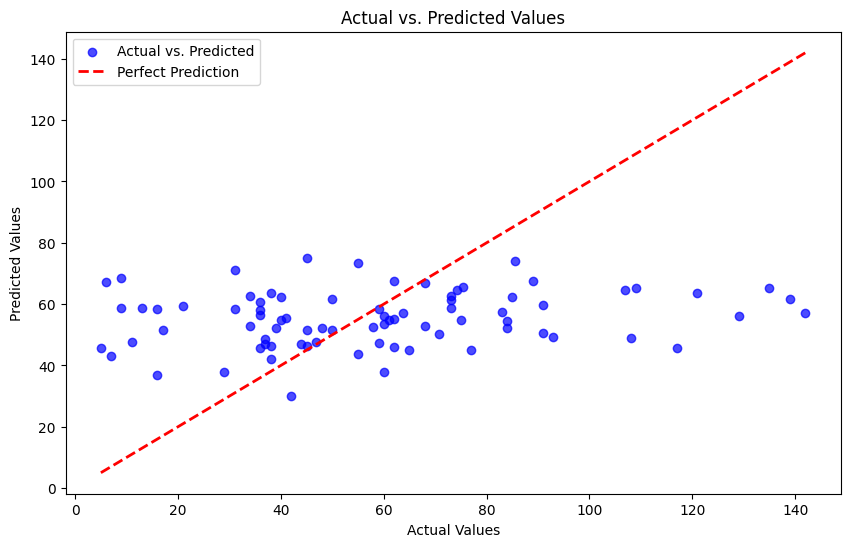

In [32]:
# @title Random Forest
model_name = "RandomForest"

# Define the Random Forest Regressor
rf_regressor = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(rf_regressor, param_grid, cv=5,
                              scoring={'mae': make_scorer(mean_absolute_error)},
                              refit='mae', return_train_score=True)

# Fit the GridSearchCV object to the data
grid_search_rf.fit(X_train, y_train)

# Get the best model from the grid search
best_rf_regressor = grid_search_rf.best_estimator_

# Calculate metrics for the best model
train_pred = best_rf_regressor.predict(X_train)
test_pred = best_rf_regressor.predict(X_test)
train_mse, train_mae, train_r2 = reg_metrics(y_train, train_pred)
test_mse, test_mae, test_r2 = reg_metrics(y_test, test_pred)

# Append the metrics to the lists
model_names.append(model_name)
train_mses.append(train_mse)
test_mses.append(test_mse)
train_maes.append(train_mae)
test_maes.append(test_mae)
train_r2s.append(train_r2)
test_r2s.append(test_r2)

# Print the appended results
print("Model Name :", model_name)
print("Best Parameters:", grid_search_rf.best_params_)
print("Train MAE  :", train_mae)
print("Test MAE   :", test_mae)
print("Train R2   :", train_r2)
print("Test R2    :", test_r2)

# Print cross-validated scores
cv_results = grid_search_rf.cv_results_
print("Cross-validated scores:")
for mean_score, params in zip(cv_results["mean_test_mae"], cv_results["params"]):
    print(f"Mean MAE: {mean_score:.4f}, Parameters: {params}")

plot_output(y_test, test_pred)

## XGBoost

Cross-validated scores:
Mean MAE: 20.2071, Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}
Mean MAE: 20.4223, Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200}
Mean MAE: 20.6513, Parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300}
Mean MAE: 20.7607, Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
Mean MAE: 21.2064, Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200}
Mean MAE: 21.3275, Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300}
Mean MAE: 20.9951, Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Mean MAE: 21.0697, Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200}
Mean MAE: 21.0789, Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}
Mean MAE: 20.3492, Parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}
Mean MAE: 20.7958, Parameters: {'learning_rate': 0.1, 'ma

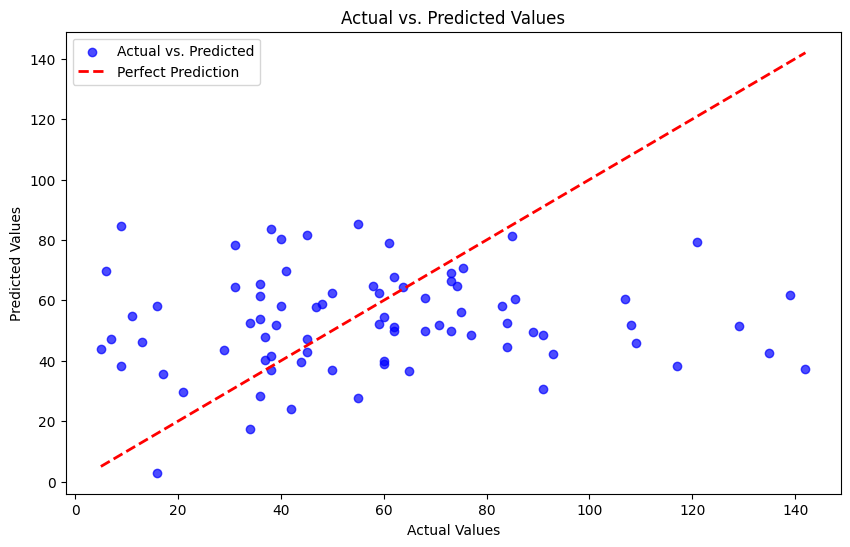

In [33]:
# @title XGB
# Define the XGBoost regressor
xgb_regressor = XGBRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Create the GridSearchCV object with mean absolute error as the scoring metric
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid,
                           scoring={'mae': make_scorer(mean_absolute_error)},
                           cv=5, refit='mae', return_train_score=True)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print cross-validated scores
cv_results = grid_search.cv_results_
print("Cross-validated scores:")
for mean_score, params in zip(cv_results["mean_test_mae"], cv_results["params"]):
    print(f"Mean MAE: {mean_score:.4f}, Parameters: {params}")

# Get the best model from the grid search
best_xgb_regressor = grid_search.best_estimator_

# Calculate metrics for the best model
train_pred = best_xgb_regressor.predict(X_train)
test_pred = best_xgb_regressor.predict(X_test)
train_mse, train_mae, train_r2 = reg_metrics(y_train, train_pred)
test_mse, test_mae, test_r2 = reg_metrics(y_test, test_pred)

# Append the metrics to the lists
model_names.append(model_name)
train_mses.append(train_mse)
test_mses.append(test_mse)
train_maes.append(train_mae)
test_maes.append(test_mae)
train_r2s.append(train_r2)
test_r2s.append(test_r2)

# Print the appended results
print("Model Name :", model_name)
print("Best Parameters:", grid_search.best_params_)
print("Train MAE  :", train_mae)
print("Test MAE   :", test_mae)
print("Train R2   :", train_r2)
print("Test R2    :", test_r2)
plot_output(y_test, test_pred)

## MLP

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conver

Cross-validated scores:
Mean MAE: 20.6985, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Mean MAE: 23.2884, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}
Mean MAE: 20.6008, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Mean MAE: 22.8169, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
Mean MAE: 20.6815, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (200,), 'solver': 'adam'}
Mean MAE: 22.5664, Parameters: {'activation': 'relu', 'hidden_layer_sizes': (200,), 'solver': 'sgd'}
Mean MAE: 21.0482, Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'solver': 'adam'}
Mean MAE: 21.6074, Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'solver': 'sgd'}
Mean MAE: 20.1392, Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Mean MAE: 22.9986, Parameters: {'activation': 'tanh', 'hidden_laye

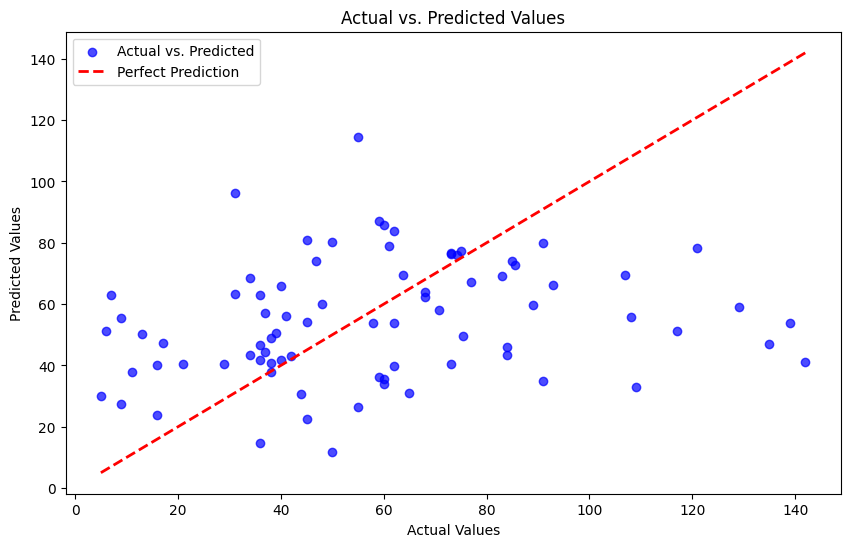

In [37]:
# @title MLP
from sklearn.neural_network import MLPRegressor
model_name = "MLP"

# Define the MLP Regressor
mlp_regressor = MLPRegressor(max_iter=500, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=mlp_regressor, param_grid=param_grid,
                           scoring={'mae': make_scorer(mean_absolute_error)},
                           cv=5, refit='mae', return_train_score=True)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print cross-validated scores
cv_results = grid_search.cv_results_
print("Cross-validated scores:")
for mean_score, params in zip(cv_results["mean_test_mae"], cv_results["params"]):
    print(f"Mean MAE: {mean_score:.4f}, Parameters: {params}")

# Get the best model from the grid search
best_mlp_regressor = grid_search.best_estimator_

# Calculate metrics for the best model
train_pred = best_mlp_regressor.predict(X_train)
test_pred = best_mlp_regressor.predict(X_test)
train_mse, train_mae, train_r2 = reg_metrics(y_train, train_pred)
test_mse, test_mae, test_r2 = reg_metrics(y_test, test_pred)

# Append the metrics to the lists
model_names.append(model_name)
train_mses.append(train_mse)
test_mses.append(test_mse)
train_maes.append(train_mae)
test_maes.append(test_mae)
train_r2s.append(train_r2)
test_r2s.append(test_r2)

# Print the appended results
print("Model Name :", model_name)
print("Best Parameters:", grid_search.best_params_)
print("Train MAE  :", train_mae)
print("Test MAE   :", test_mae)
print("Train R2   :", train_r2)
print("Test R2    :", test_r2)
plot_output(y_test, test_pred)


## Decision Tree

Cross-validated scores:
Mean MAE: 23.4898, Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean MAE: 23.3495, Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}
Mean MAE: 23.2070, Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Mean MAE: 23.5910, Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Mean MAE: 23.5981, Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
Mean MAE: 23.3695, Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Mean MAE: 22.9445, Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mean MAE: 22.9445, Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Mean MAE: 22.9836, Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean MAE: 27.1306, Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean MAE: 27.2853, Par

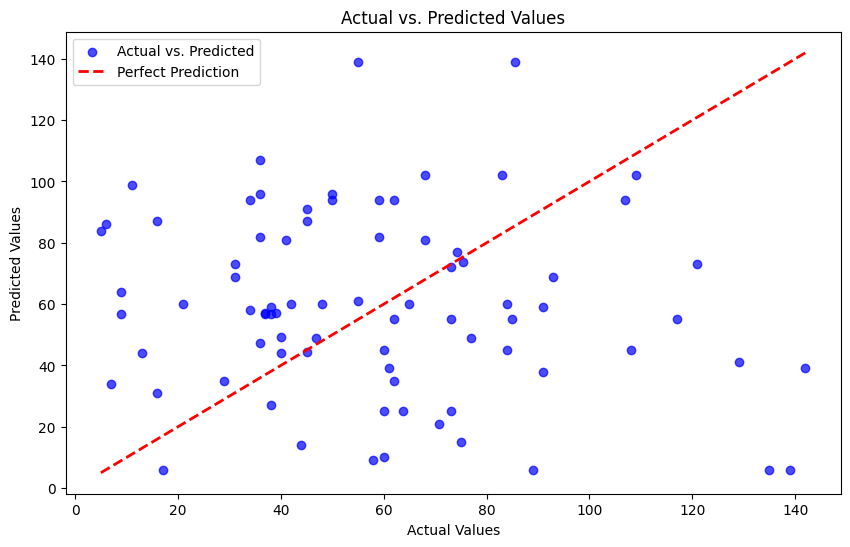

In [39]:
# @title Decision Tree
from sklearn.tree import DecisionTreeRegressor
model_name = "Decision Tree"

# Define the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid,
                           scoring={'mae': make_scorer(mean_absolute_error)},
                           cv=5, refit='mae', return_train_score=True)



# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print cross-validated scores
cv_results = grid_search.cv_results_
print("Cross-validated scores:")
for mean_score, params in zip(cv_results["mean_test_mae"], cv_results["params"]):
    print(f"Mean MAE: {mean_score:.4f}, Parameters: {params}")



# Get the best model from the grid search
best_dt_regressor = grid_search.best_estimator_

# Calculate metrics for the best model
train_pred = best_dt_regressor.predict(X_train)
test_pred = best_dt_regressor.predict(X_test)
train_mse, train_mae, train_r2 = reg_metrics(y_train, train_pred)
test_mse, test_mae, test_r2 = reg_metrics(y_test, test_pred)

# Append the metrics to the lists
model_names.append(model_name)
train_mses.append(train_mse)
test_mses.append(test_mse)
train_maes.append(train_mae)
test_maes.append(test_mae)
train_r2s.append(train_r2)
test_r2s.append(test_r2)

# Print the appended results
print("Model Name :", model_name)
print("Best Parameters:", grid_search.best_params_)
print("Train MAE  :", train_mae)
print("Test MAE   :", test_mae)
print("Train R2   :", train_r2)
print("Test R2    :", test_r2)
plot_output(y_test, test_pred)


## Save Model

In [40]:
## select the model based on the lowest test MAE
print('Models: ', model_names)
print('MAEs: ', test_maes)

Models:  ['LassoRegression', 'RandomForest', 'RandomForest', 'MLP', 'MLP', 'Decision Tree', 'Decision Tree']
MAEs:  [25.564583333333335, 24.824308134920635, 27.334264449278514, 26.62843749996002, 26.62843749996002, 37.41979166666667, 37.41979166666667]


In [41]:
import pickle

# Save the model to a file using pickle
with open('./drive/MyDrive/ML assignment/best_reg_model.pkl', 'wb') as file:
    pickle.dump(best_rf_regressor, file)
